<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3136/logos/header.png'>
* ref : kaggle  : https://www.kaggle.com/c/titanic/overview
    
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

import warnings
warnings.filterwarnings(action='ignore')


# Data Collection

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sub = pd.read_csv("./submission.csv")

# EDA(Explorer Data Analysis)

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.head()  #test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### target label 확인(분포, 값)

In [7]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
print(train[train['Survived']==0]['Survived'].count() / train.shape[0] * 100)
print(train[train['Survived']==1]['Survived'].count() / train.shape[0] * 100)

61.61616161616161
38.38383838383838


# 결측 확인(Missing Value)

In [9]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
train_test = train.append(test)
train_test.shape

(1309, 12)

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

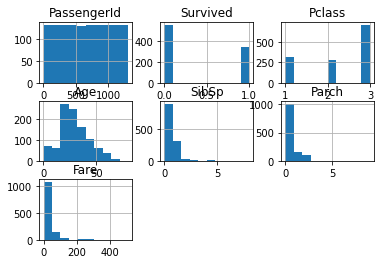

In [12]:
train_test.hist()

In [13]:
train_test.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## 공통함수

In [14]:
def nan_check():
    nan_dict = {"CNT" : train_test.isna().sum(),
                "RATE" :train_test.isna().sum() / train_test.shape[0] * 100 }
    nan_df = pd.DataFrame(nan_dict)
    return nan_df.head(20).T
nan_check()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
CNT,0.0,418.000000,0.0,0.0,0.0,263.000000,0.0,0.0,0.0,1.000000,1014.000000,2.000000
RATE,0.0,31.932773,0.0,0.0,0.0,20.091673,0.0,0.0,0.0,0.076394,77.463713,0.152788


# Feature Engineering (가공)

###  1.. 인코딩(encoding) : Object --> numeric 타입 변환
<pre>
3   Name         891 non-null    object  ---> Mr.Miss.
4   Sex          891 non-null    object  ---> 1/0
8   Ticket       891 non-null    object  ---> drop
10  Cabin        204 non-null    object  ---> A~E??? 
11  Embarked     889 non-null    object  ---> 0/1/2
</pre>

* 10  Cabin        204 non-null    object  ---> A~E??? 

In [15]:
"hello"[1:3]

'el'

In [16]:
train_test['Cabin'].fillna('U0', inplace=True)
# print(train_test['Cabin'].str[0:1].value_counts())
train_test['Cabin'] = train_test['Cabin'].str[0:1]
train['Cabin'] = train['Cabin'].str[0:1]

cross = pd.crosstab(train['Cabin'], train['Survived'])
cross


Survived,0,1
Cabin,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
T,1,0


In [17]:
cross = pd.crosstab(train['Cabin'], train['Pclass'])
cross

Pclass,1,2,3
Cabin,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0


* 4   Sex          891 non-null    object  ---> 1/0
* 11  Embarked     889 non-null    object  ---> 0/1/2
-----
1. 인코딩
2. 원핫인코딩
3. (1+2)df.get_dummy()
4. map(), apply(), lambda

In [18]:
train_test.shape

(1309, 12)

In [19]:
cp1 = train_test[["Sex","Embarked"]].head()
cp1 = cp1.replace("male",1)
cp1 = cp1.replace("female",0)
cp1.head()

,Sex,Embarked
0,1,S
1,0,C
2,0,S
3,0,S
4,1,S


In [20]:
cp2 = train_test[["Sex","Embarked"]].head()
cp2.head()
dict = {"male":0, "female":1}
cp2["Sex22"] = cp2["Sex"].map(dict)
cp2.head()

,Sex,Embarked,Sex22
0,male,S,0
1,female,C,1
2,female,S,1
3,female,S,1
4,male,S,0


In [21]:
cp3 = train_test[["Sex","Embarked"]].head()
cp3["Sex22"] = cp3["Sex"].apply(lambda x : 1 if x=='male' else 0)
cp3.head()

,Sex,Embarked,Sex22
0,male,S,1
1,female,C,0
2,female,S,0
3,female,S,0
4,male,S,1


In [22]:
print(train_test["Embarked"].unique())        
print(train_test["Embarked"].nunique())        
print(train_test["Embarked"].value_counts())  #S
print(train_test["Embarked"].mode())          #최빈값

['S' 'C' 'Q' nan]
3
S    914
C    270
Q    123
Name: Embarked, dtype: int64
0    S
dtype: object


In [23]:
train_test["Embarked"].fillna("S", inplace=True)
train_test["Embarked"].isna().sum()

0

In [24]:
#train_test["Embarked"].fillna(train_test["Embarked"].mode(), inplace=True)
#train_test["Embarked"].isna().sum()

In [25]:
cp4 = train_test[["Sex","Embarked"]].head()
#'S'0 'C'1 'Q'2 
cp4["Embarked22"] = cp3["Embarked"].apply(lambda x : 0 if x=='S' else (1 if x=='C' else 2) )
cp4.head()

,Sex,Embarked,Embarked22
0,male,S,0
1,female,C,1
2,female,S,0
3,female,S,0
4,male,S,0


In [26]:
train_test["Sex"] = train_test["Sex"].apply(lambda x : 1 if x=='male' else 0)
dict = {'S':0, 'C':1, 'Q':2 }
train_test["Embarked"] = train_test["Embarked"].map(dict)
train_test[["Sex","Embarked"]].head()

,Sex,Embarked
0,1,0
1,0,1
2,0,0
3,0,0
4,1,0


In [27]:
print(train_test["Embarked"].unique())    

[0 1 2]


In [28]:
# train_test = pd.get_dummies(train_test)
# train_test.shape
# train_test.head()

### 2.. 결측값 채우기

* Age            177  --> 호칭별 그룹 평균값
* Cabin          687  --> 너무도 많은(50%이상) 결측 버린다
* Embarked         2  --> 최빈값(빈도가 가장 많은)
* Fare             1  --> 유사한 [동행자수,등급] (평균값)
----
df.fillna()

In [29]:
train_test["Name_title"] = train_test["Name"].str.extract('([A-Za-z]+)\.')
train_test["Name_title"].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Name_title, dtype: int64

In [30]:
 train_test[train_test["Age"].isna()]["Name_title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Ms'], dtype=object)

In [31]:
title_map = {'Mr':0, 
       'Miss':1, 'Mlle':1, 'Ms':1, 'Lady':1,
       'Mrs':2, 'Mme':2,
       'Master':3, 'Dr':3, 'Sir':3,
       'Rev':4, 'Col':4, 'Major':4, 'Don':4, 'Capt':4, 'Countess':4, 'Jonkheer':4, 'Dona':4}
train_test["Name_title"] = train_test["Name_title"].map(title_map)
train_test[["Name","Name_title"]].head()

,Name,Name_title
0,"Braund, Mr. Owen Harris",0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2
2,"Heikkinen, Miss. Laina",1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2
4,"Allen, Mr. William Henry",0


In [32]:
# train_test.groupby(by="Name_title")["Age"].mean()
print(train_test["Age"].isna().sum())
train_test["Age"] = train_test["Age"].fillna(  train_test.groupby(by="Name_title")["Age"].transform('mean')   )


print(train_test["Age"].isna().sum())

263
0


#### 결측처리를 위한 파생변수 생성

* family = SibSp + Parch
* SibSp, Parch --- 삭제

In [33]:
train_test['family'] = train_test['SibSp'] + train_test['Parch'] + 1
train_test[['family','SibSp','Parch','Pclass','Fare']].head(20)

,family,SibSp,Parch,Pclass,Fare
0,2,1,0,3,7.2500
1,2,1,0,1,71.2833
2,1,0,0,3,7.9250
3,2,1,0,1,53.1000
4,1,0,0,3,8.0500
5,1,0,0,3,8.4583
6,1,0,0,1,51.8625
7,5,3,1,3,21.0750
8,3,0,2,3,11.1333
9,2,1,0,2,30.0708


In [34]:
#train_test[train_test['Fare'].isna()]
train_test[train_test['Fare'].isna()][['family','SibSp','Parch','Pclass','Fare']]

,family,SibSp,Parch,Pclass,Fare
152,1,0,0,3,NaN


In [35]:
print(train_test['Fare'].isna().sum())
mean_fare = train_test[(train_test['family']==1) & (train_test['Pclass']==3)]["Fare"].mean()
mean_fare = np.round(mean_fare,4)
print(mean_fare)
train_test['Fare'] = train_test['Fare'].fillna(mean_fare)
print(train_test['Fare'].isna().sum())

1
9.0967
0


### 3.. 정규분포(표준화)
* 왜도(좌우 치우침)
* 첨도(중앙값 부근으로 값이 치우침)

### 4.. 스케일링(값의 지수화 == 수치 맞추기)
* 값의 수치를 하나의 기준으로 맞추고 크고 작음을 비교

### 5.. 이상값(Outlier) 처리

### 7. 구간화(바인딩)
* Age : 0 ~10  : 1
        11~20  : 2

In [36]:
train_test.isna().sum()
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   int64  
 12  Name_title   1309 non-null   int64  
 13  family       1309 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 153.4+ KB


# <font color=red>TODO</font>

In [37]:
sample_df = pd.DataFrame({'A': [1,2,3], 'B': [10,20,30] })
sample_df.head()

,A,B
0,1,10
1,2,20
2,3,30


In [38]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html
# Returns DataFrame : A DataFrame that must have the same length as self.

sample_df = pd.DataFrame({'A': [1,2,3], 'B': [10,20,30] })
# sample_df.apply(lambda x:x.mean())        #agg[집계] 
# sample_df.apply(lambda x:np.exp(x))       #input==output rows

# sample_df.transform(lambda x:x.mean())    #agg[집계] error
# sample_df.transform('mean')

# sample_df.transform(lambda x: np.exp(x))  #input==output rows
# sample_df.transform(np.exp)
sample_df.transform('exp')

,A,B
0,2.718282,2.202647e+04
1,7.389056,4.851652e+08
2,20.085537,1.068647e+13


In [39]:
sample_df = pd.DataFrame({
    'key': ['a','b','c'] * 2,
    'age': np.arange(6),
    'sex': ["f","m","f"] * 2,
})
sample_df

,key,age,sex
0,a,0,f
1,b,1,m
2,c,2,f
3,a,3,f
4,b,4,m
5,c,5,f


In [40]:
# Aggregating the sum of the given Series
def group_mean(x):
    return x.mean()
# grp_apply = sample_df.groupby('key')['age'].apply(group_mean)   #0+3, 1+4, 2+5
# print(grp_apply, grp_apply.index)

grp_trans = sample_df.groupby('key')['age'].transform('mean')
print(grp_trans, grp_trans.index)

0    1.5
1    2.5
2    3.5
3    1.5
4    2.5
5    3.5
Name: age, dtype: float64 RangeIndex(start=0, stop=6, step=1)


In [41]:
def mydef(x):
    return x+10
print(sample_df)

  key  age sex
0   a    0   f
1   b    1   m
2   c    2   f
3   a    3   f
4   b    4   m
5   c    5   f


In [42]:
#------------- DataFrame.groupby().FUNCTION(mydef)
# sample_df.groupby('key').apply(mydef)       #--- type error : sex+10
sample_df.groupby('key').transform('mean')   #--- 연산가능피쳐 알아서 필터링

#------------- DataFrame.groupby().['컬럼'].FUNCTION(mydef)
# sample_df.groupby('key')['age'].apply(mydef) == sample_df.groupby('key')['age'].transform(mydef)

#------------- DataFrame.groupby().FUNCTION(lambda x: mydef(x['컬럼']))
# print(sample_df.groupby('key').apply(lambda x: mydef(x['age'])).index)
# sample_df.groupby('key').apply(lambda x: mydef(x['age']))  #컬럼명을 메서드안에 명시 --> 그룹별 series리턴

# # sample_df.groupby('key').transform(lambda x: mydef(x['age']))  #컬럼명을 메서드안에 명시 --> error
# sample_df.groupby('key').transform(lambda x: x*10)               

# sample_df.groupby('key')['age'].transform('mean')

# sample_df.groupby(by="Name_title")["Age"].transform('mean')

,age
0,1.5
1,2.5
2,3.5
3,1.5
4,2.5
5,3.5


In [43]:
train_test2 = train_test.copy()
mean_fare=train_test2[(train_test2['family']==1)&(train_test2['Pclass']==3)]["Fare"].mean()
mean_fare

9.096707203389837

In [44]:
# A=train_test2["Age"] = train_test2["Age"].fillna(train_test2.groupby(by="Name_title")["Age"].transform('mean'))
# A   #--정상실행

# train_test2.groupby(by="Name_title")["Age"].transform('mean')  #--정상실행
# mean_fare = train_test[(train_test['family']==1) & (train_test['Pclass']==3)]["Fare"].mean() #--정상실행

#--- groupby 없이 trainsform(집계함수) 사용
#--- 입력 레코드와 결과레코드 수가 다르다 -- 에러!!!
#--- # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html
#--- Returns DataFrame : A DataFrame that must have the same length as self.  (!!!  must have the same length)
# mean_fare = train_test[(train_test['family']==1) & (train_test['Pclass']==3)]["Fare"].transform('mean') 





## 삭제 컬럼

In [45]:
drop_cols = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin']  #점수보고 지우자 
train_test.drop(drop_cols, axis=1, inplace=True)

In [46]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   Embarked    1309 non-null   int64  
 6   Name_title  1309 non-null   int64  
 7   family      1309 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 92.0 KB


-------------
## 점수 높이기 시도

## Age 구간화

<AxesSubplot:xlabel='Age', ylabel='Count'>

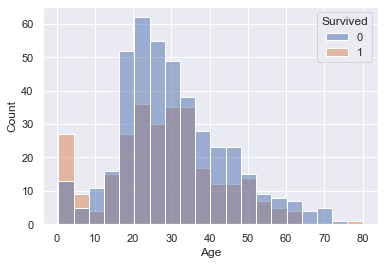

In [47]:
sns.set()
sns.histplot(data=train, x="Age", hue="Survived")
# plt.show()

In [48]:
train_test["Age"] = np.round(train_test["Age"],0).astype('int64')
train_test["Age"] = np.round(train_test["Age"],0).astype('int64')

In [49]:
train_test.loc[train_test['Age']<=16, 'Age_band1'] = 1
train_test.loc[(train_test['Age']>16) & (train_test['Age']<=34), 'Age_band1'] = 2
train_test.loc[(train_test['Age']>34) & (train_test['Age']<=48), 'Age_band1'] = 3
train_test.loc[(train_test['Age']>48) & (train_test['Age']<=67), 'Age_band1'] = 4
train_test.loc[train_test['Age']>67, 'Age_band1'] = 5

In [50]:
train_test['Age_band2'] = pd.cut(train_test['Age'], bins=[0, 16, 34, 48, 67, 90], labels=[1,2,3,4,5])

In [51]:
train_test['Age_band3']  = train_test['Age'] // 10 

In [52]:
train_test['Age_band1'] = train_test['Age_band1'].astype('int64')
train_test['Age_band1'].unique() #.isna().sum()
train_test[['Age','Age_band1','Age_band2','Age_band3']].head()

,Age,Age_band1,Age_band2,Age_band3
0,22,2,2,2
1,38,3,3,3
2,26,2,2,2
3,35,3,3,3
4,35,3,3,3


In [53]:
del_col = ['Age','Age_band2','Age_band3']  #'Age_band1' 남겨둘 경우
train_test.drop(del_col, axis=1, inplace=True)

# 학습

#### train - test 분리

In [54]:
train.shape[0], test.shape[0]

(891, 418)

In [55]:
train_test["Survived"].isna().sum()

418

In [56]:
train = train_test[~train_test["Survived"].isna()]
test = train_test[train_test["Survived"].isna()]
train.shape, test.shape

((891, 8), (418, 8))

In [57]:
train = train_test.iloc[:train.shape[0]]
test = train_test.iloc[train.shape[0]:]
train.shape, test.shape

((891, 8), (418, 8))

In [58]:
# test.drop('Survived', axis=1, inplace=True)
test = test.drop('Survived', axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Fare        418 non-null    float64
 3   Embarked    418 non-null    int64  
 4   Name_title  418 non-null    int64  
 5   family      418 non-null    int64  
 6   Age_band1   418 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 26.1 KB


In [59]:
train["Survived"] = train["Survived"].astype('int64')

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Embarked    891 non-null    int64  
 5   Name_title  891 non-null    int64  
 6   family      891 non-null    int64  
 7   Age_band1   891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


In [61]:
train.shape, test.shape

((891, 8), (418, 7))

### 학습모델 선정 : 우선 점수부터 보자
* 숫자로만 이루어져있다
* 결측이 다

In [62]:
from sklearn.tree import DecisionTreeClassifier       #class
from sklearn.ensemble import RandomForestClassifier   #class
from sklearn.metrics import accuracy_score            #def
from sklearn.model_selection import train_test_split  #def

In [63]:
# -----------------------------------------------
# ***train_test_split()
# 학습[****fit()]     train 8 ---
# 예측[****predict()] train 2 --- validation
# 평가[****score()]  (점수)  --- A
# ----------------------------------model
# 예측 test 
# 평가(점수)   --- B 오버피팅/언더피팅
# -----------------------------------------------
# 검증
# -----------------------------------------------
# 튜닝        --- 분석가 XGBoost 40~80
# -----------------------------------------------

In [64]:
# dt_model = DecisionTreeClassifier()
dt_model = RandomForestClassifier()

In [65]:
답안지 = train["Survived"]
문제지 = train.drop("Survived", axis=1)
print(문제지.shape, 답안지.shape)
문제지.head()
답안지.head()

#X_train, X_val,   y_train, y_val 
문제지8, 문제지2, 답안지8, 답안지2 = train_test_split(문제지, 답안지, test_size=0.2)
dt_model.fit(문제지8, 답안지8)  #기계학습

# ---------------------검증 (train2) 셀프테스트 -----------------------
컴퓨터가낸답안2 = dt_model.predict(문제지2)
acc_score = accuracy_score(답안지2, 컴퓨터가낸답안2)
print("모델점수", acc_score)

(891, 7) (891,)
모델점수 0.7821229050279329


In [66]:
def my_eval_chart(답안지2, proba): 
# --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
    auc_score = roc_auc_score(답안지2, proba[:, 1])

    fprs, tprs, ths = roc_curve(답안지2, proba[:, 1])
    plt.title("roc curv %0.4f" % auc_score)
    # plt.title(f"precision recall curv %0.4f" % f1)
    plt.xlabel("FPR(1-specificity)")
    plt.ylabel("TPR")
    plt.grid()
    plt.plot(fprs, tprs, "b")
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.show()

In [67]:
def my_eval(답안지2, pred, proba, chart=False):  #avg='binary'
    accuracy = accuracy_score(답안지2, pred)
    precision = precision_score(답안지2, pred)
    recall = recall_score(답안지2, pred)
    f1 = f1_score(답안지2, pred)
    matrix = confusion_matrix(답안지2, pred)
    print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
    print("오차행렬\n", matrix)
    # cls_report = classification_report(y_val, pred)    
    if chart==True:
        my_eval_chart(답안지2, proba)

def fit_score(문제지8, 문제지2, 답안지8, 답안지2, model=None, test_size=0.2):
    model.fit(문제지8, 답안지8)
    pred = model.predict(문제지2)                                        #[0  1]              th:0.5
    proba = model.predict_proba(문제지2)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
    my_eval(답안지2, pred, proba) 
    
scalers = [StandardScaler()]  #, RobustScaler(), MinMaxScaler()]
for mm in scalers:
    mm.fit(문제지8)                       #비율계산
    scaler_X_train = mm.transform(문제지8)  #계산반영해
    scaler_X_test = mm.transform(문제지2)  #계산반영해
    
    print(mm.__class__.__name__)
    fit_score(scaler_X_train, scaler_X_test, 답안지8, 답안지2, dt_model)

StandardScaler
정확도0.7933 정밀도:0.7966 재현률:0.6528 f1:0.7176
오차행렬
 [[95 12]
 [25 47]]


In [68]:
import xgboost as xgb
# import lightgbm

In [69]:
xgmodel = xgb.XGBClassifier(n_estimators=300, objective="binary:logistic")   #logloss 
fit_score(scaler_X_train, scaler_X_test, 답안지8, 답안지2, xgmodel) 

[11:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
정확도0.7877 정밀도:0.7833 재현률:0.6528 f1:0.7121
오차행렬
 [[94 13]
 [25 47]]


In [70]:
scaler_X = np.concatenate([scaler_X_train, scaler_X_test])
y = pd.concat([답안지8, 답안지2], axis=0, ignore_index=True)
print(scaler_X.shape, y.shape)

(891, 7) (891,)


In [71]:
accuracy_total_score = []
f1_total_score = []
auc_total_score = []

skfold = StratifiedKFold(n_splits=5, random_state=1414, shuffle=True)
for train_index, test_index in skfold.split(scaler_X, y):
    문제지8, 문제지2 = scaler_X[train_index], scaler_X[test_index]
    정답지8, 정답지2 = y[train_index], y[test_index]
   #train_test_split(문제지,정답지, test_sizse=0.2, random_state=1414, shuffle=False) ----
    dt_model.fit(문제지8, 정답지8)
    pred = dt_model.predict(문제지2)
    proba = dt_model.predict_proba(문제지2)
    
    accuracy = accuracy_score(정답지2, pred)
    f1 = f1_score(정답지2, pred)
    auc = roc_auc_score(정답지2, proba[:, 1])
    
    accuracy_total_score.append(accuracy)
    f1_total_score.append(f1)
    auc_total_score.append(auc)


# print("평균", sum(accuracy_total_score) / len(accuracy_total_score))
print("평균 정확도 : ", np.array(accuracy_total_score).mean())
print("평균 F1 :", np.array(f1_total_score).mean())  
print("평균 AUC :", np.array(auc_total_score).mean())  

평균 정확도 :  0.8147950536689474
평균 F1 : 0.7551076890086177
평균 AUC : 0.8514133723257589


In [72]:
# 모델점수 
# 0.770949720670391
# 0.8156424581005587 --->  0.75358 (over fitting)
# 0.8212290502793296
# 0.8603351955307262

In [73]:
test.shape

(418, 7)

## 학습 주요 피쳐 

In [74]:
문제지.columns.values

array(['Pclass', 'Sex', 'Fare', 'Embarked', 'Name_title', 'family',
       'Age_band1'], dtype=object)

In [75]:
np.round(dt_model.feature_importances_*100 , 3)

array([ 8.099, 16.723, 34.285,  3.714, 20.504, 10.413,  6.261])

In [76]:
sub.shape, test.shape

((418, 2), (418, 7))

In [77]:
# ---------------------리더보드 제출용 (test) 본테스트-----------------------
컴퓨터가낸답안418 = dt_model.predict(test)
print(len(컴퓨터가낸답안418))
컴퓨터가낸답안418[:10]

418


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [78]:
dict = {"featue":문제지.columns.values, "imp":np.round(dt_model.feature_importances_*100 , 3)}
impdf = pd.DataFrame(dict)
impdf = impdf.set_index("featue")
# impdf.head()
impdf.sort_values("imp", ascending=False).T

featue,Fare,Name_title,Sex,family,Pclass,Age_band1,Embarked
imp,34.285,20.504,16.723,10.413,8.099,6.261,3.714


## 공모전용 답안지 제출

In [79]:
sub["Survived"] = 컴퓨터가낸답안418.reshape(-1,1)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [80]:
sub.to_csv("./submission_AJC_v02.csv", index=False)

In [81]:
df = pd.read_csv("./submission_AJC_v02.csv")
df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
